In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os

In [2]:
# TODO:
# Obtención de trayectorias válidas sin bucles!
# Cambiar a comienzo en (3,3),
#  (Es el verdadero centro + es más fácil encontrar trayectorias válidas que partan de el (más hueco))
# Resolver simetrias
# - Dada una trayectoria válida, todas sus simétricas lo son.
# Obtención incremental
# - Ir pegango caminos compatibles
# FUTURE:
# Generación de alrbol de derivación de la gramática
# Clonadores:
# - Aleatorios
# - Que puedan generar la gramática
# Algoritmo genético


In [15]:
PREFIX = 0
SUFFIX = -1

X = 0
Y = 1

A = np.asarray([2,1])
B = np.asarray([1,2])
C = np.asarray([-1,2])
D = np.asarray([-2,1])
E = np.asarray([-2,-1])
F = np.asarray([-1,-2])
G = np.asarray([1,-2])
H = np.asarray([2,-1])

BOARD_SIZE=8
MOVES = {'A':A, 'B':B, 'C':C, 'D':D, 'E':E, 'F':F, 'G':G, 'H':H}
DICT = 'ABCDEFGH'
START=(0,0)

def get_combinations(l=2):
    '''
    retrieves all combinations of words of given length.
    '''
    return ["".join(item) for item in itertools.product(DICT, repeat=l)]

def has_loop(string, exact=False, only_exact = False):
    '''
    checks if the word contains any loop
    only_exact: check if the word contains a single loop with the same length as of the word  
    exact: check only if the word contains a loop with the same length as the word
    '''
    checked = []
    if only_exact:
        return has_loop(string,exact=True) and not has_loop(string[:-1])
    elif exact:
        return np.abs(get_locs_move(parse_moves(string))[-1]).sum() == 0
    else:
        for to_check in get_locs_move(parse_moves(string)):
            for obj in checked:
                if np.sum(np.abs(obj - to_check)) == 0:
                    return True
            checked.append(to_check)
        return False

def is_valid(string, start = START, size=BOARD_SIZE):
    '''
    checks if the the movement described by the word is valid, given a starting position and a board size.
    '''
    locs = get_locs_move(parse_moves(string)) - np.asarray(start)
    return is_in_range(locs, BOARD_SIZE)

def is_in_range(locs, start = START):
    '''
    checks if all coordinates given in locs are inside the board
    '''
    return np.sum((np.asarray(locs) >= BOARD_SIZE) | (np.asarray(locs) < 0)) == 0

def is_not_valid(string, start = START, size=BOARD_SIZE):
    '''
    checks if the the movement described by the word is not valid, given a starting position and a board size.
    '''
    return not is_valid(string, start, size)

def clean_language(language, start = START, size=BOARD_SIZE):
    '''
    removes words containing a loop or overflowing the board from a given language.
    '''
    return [word for word in language if is_valid(word, start, size) and not has_loop(word)]

def random_word(length = 4):
    '''
    return a random word of a given length
    '''
    return "".join(np.random.choice(list(DICT),size=length, replace=True))

def random_set(size=100,length=4):
    '''
    return a random set of given length containing words of a given length
    '''
    return np.asarray([random_word(length) for _ in range(size)])

def parse_moves(string):
    '''
    converts a string of movements to an array of displacements
    '''
    return np.asarray([MOVES[char] for char in string])

def get_locs_move(moves, start = START):
    '''
    converts a string of movements to an array of locations as thos moves are applied to the given start position.
    '''
    init = np.asarray(start)
    return np.vstack((init,np.cumsum(moves, axis=-0)+start))

def plot_move(string_move,start=START):
    pass

def plot_board(size=BOARD_SIZE):
    '''
    plots the board
    '''
    for i in range(size):
        plt.plot([ -.5, size -.5],[i-.5,i-.5],color='k')
        plt.plot([i-.5,i-.5],[0-.5,size-.5],color='k')
    

def plot_moves(string, start=START, size=BOARD_SIZE, center=False):
    '''
    plots a trajectory.
    center: when false, only display the board, when true center the trajectory to display.
    '''
    moves = get_locs_move(parse_moves(string),start)
    plt.figure(figsize=(5,5))
    
    plot_board()
    
    for i in range(len(moves)-1):
        dx = [moves[i][X],moves[i+1][X]]
        dy = [moves[i][Y],moves[i+1][Y]]
        plt.plot(dx, dy, color='r', marker='s', markersize=10)
        if is_in_range([moves[i+1][X], moves[i][Y]], BOARD_SIZE) and is_in_range([moves[i+1][X], moves[i+1][Y]], BOARD_SIZE):
            plt.text(moves[i][X], moves[i][Y], '${}$'.format(i+1), fontsize=20)
        plt.text(np.mean(dx), np.mean(dy), string[i], fontsize=20)
    # final dot
    if is_in_range([moves[-1][X], moves[-1][Y]]):
        plt.text(moves[-1][X]+.2, moves[-1][Y]+.2, '${}$'.format(len(moves)), fontsize=20)
    
    if center:
        pass
    else:
        plt.xlim(-.5,BOARD_SIZE-1+.5)
        plt.ylim(-.5,BOARD_SIZE-1+.5)
    plt.show()
    plt.close()

def get_sons(language, word):
    '''
    for a given word, gets the members in a language that are used to create another
    word in the language by gluing those members.
    '''
    sons = []
    for word_2 in language:
        # if the last character of the word_1 is the same as the word_2 and
        # the two word are glued in another word in the language
        if word[-1] == word_2[0] and "".join([word[-1],word_2[1:]]) in language:
            sons.append(word_2[1:])
    return sons

###################################################################
# Generación de caminos
###################################################################

def get_pairs(start=START,size=BOARD_SIZE):
    '''
    retrieves the paths without loops of length 2
    that are valid from a position in a board of given size.
    '''
    return [word for word in get_combinations() if is_valid(word) and not has_loop(word)]
    
def glue(prefix, suffix, odd_prefix=False):
    '''
    glues two words
    '''
    if odd_prefix:
        len_int = np.min((len(suffix)//2,len(prefix)//2))
        return prefix + suffix[len_int:]
    else:
        return prefix + suffix[len(suffix)//2:]

def matches_prefix_suffix(prefix,suffix, odd=False):
    #print(prefix,':',prefix[len(prefix)//2:],'--',suffix[:len(suffix)//2],suffix)
    if not odd:
        return np.sum(np.asarray(prefix[len(prefix)//2:]) != np.asarray(suffix[:len(suffix)//2])) == 0
    else:
        return np.sum(np.asarray(prefix[:len(suffix)//2]) != np.asarray(suffix[:len(suffix)//2])) == 0
        
    
def extend_word(prefix, language, odd=False):
    return [glue(prefix,suffix, odd) for suffix in language if matches_prefix_suffix(prefix,suffix, odd) and
            not has_loop(glue(prefix,suffix, odd))]

def get_base_grammar():
    language = [word for word in get_combinations() if not has_loop(word)]
    prefixes = {}
    suffixes = {}
    analysis = {}
    for prefix in language:
        for suffix in language:
            if matches_prefix_suffix(prefix,suffix):
                word = glue(prefix,suffix)
                if not has_loop(word):
                    if prefix not in prefixes.keys():
                        prefixes[prefix] = [word]
                    else:
                        prefixes[prefix].append(word)

                    if suffix not in suffixes.keys():
                        suffixes[suffix] = [word]
                    else:
                        suffixes[suffix].append(word)

                    analysis[word] = (prefix,suffix)
                    
    return prefixes, suffixes, analysis, language

def get_paths(word_length=4):
    ## Builds the grammar which is much more convenient
    grammar = {}
    if word_length % 2 != 0:
        raise ValueError('Parametter \'word_length\' must be an even number')
    elif word_length == 2:
        return get_base_grammar() 
    elif word_length == 4:
        prefixes, suffixes, analysis, language = get_paths(2)
        new_language = []
        # We perform two extensions
        # Odd paths have no loops in a bgraph! (only case)
        new_prefixes = {}
        new_suffixes = {}
        new_analysis = {}
        
        for hook in analysis.keys():
            joint = analysis[hook][SUFFIX]
            matches = prefixes[joint]
            for match in matches:
                word = hook + match[2:]
                if not has_loop(word):
                    if analysis[hook][PREFIX] not in new_prefixes.keys():
                        new_prefixes[analysis[hook][PREFIX]] = [word]
                    else:
                        new_prefixes[analysis[hook][PREFIX]].append(word)

                    if analysis[match][SUFFIX] not in new_suffixes.keys():
                        new_suffixes[analysis[match][SUFFIX]] = [word]
                    else:
                        new_suffixes[analysis[match][SUFFIX]].append(word)
                        
                    new_analysis[word] = (analysis[hook][PREFIX],analysis[match][SUFFIX])
                    new_language.append(word)
            
        return new_prefixes, new_suffixes, new_analysis, new_language
    else:
        new_prefixes = {}
        new_suffixes = {}
        new_analysis = {}
        new_language = []
        prefixes, suffixes, analysis, language = get_paths(word_length//2)
        
        for hook in language:
            joint = analysis[hook][SUFFIX]
            matches = prefixes[joint]
            for match in matches:
                word = hook + match[len(match)//2:]
                if not has_loop(word):
                    if analysis[hook][PREFIX] not in new_prefixes.keys():
                        new_prefixes[analysis[hook][PREFIX]] = [word]
                    else:
                        new_prefixes[analysis[hook][PREFIX]].append(word)

                    if analysis[match][SUFFIX] not in new_suffixes.keys():
                        new_suffixes[analysis[match][SUFFIX]] = [word]
                    else:
                        new_suffixes[analysis[match][SUFFIX]].append(word)
                        
                    new_analysis[word] = (analysis[hook][PREFIX],analysis[match][SUFFIX])
                    new_language.append(word)
        
        return new_prefixes, new_suffixes, new_analysis, new_language
        

In [26]:
prefixes, suffixes, analysis, language = get_paths(8)

In [22]:
suffixes.keys()

dict_keys(['AA', 'AB', 'AC', 'AD', 'AF', 'AG', 'AH', 'BA', 'BB', 'BC', 'BD', 'BE', 'BG', 'BH', 'CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CH', 'DA', 'DB', 'DC', 'DD', 'DE', 'DF', 'DG', 'FA', 'FC', 'FD', 'FE', 'FF', 'FG', 'FH', 'GA', 'GB', 'GD', 'GE', 'GF', 'GG', 'GH', 'HA', 'HB', 'HC', 'HE', 'HF', 'HG', 'HH', 'EB', 'EC', 'ED', 'EE', 'EF', 'EG', 'EH'])

In [7]:
prefixes, suffixes, analysis, language = get_paths(4)

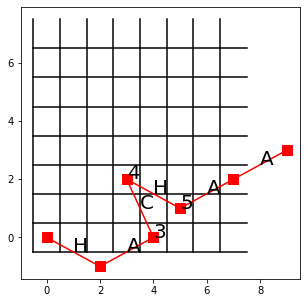

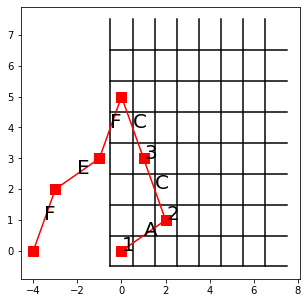

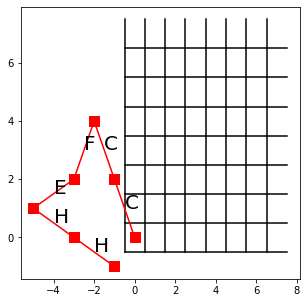

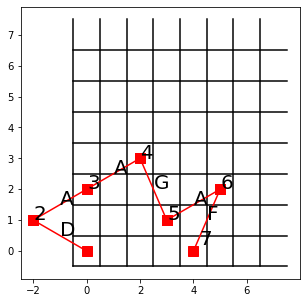

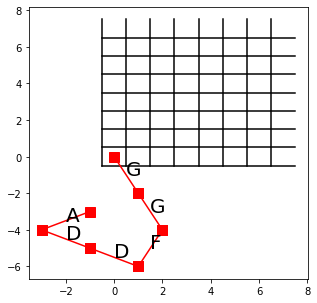

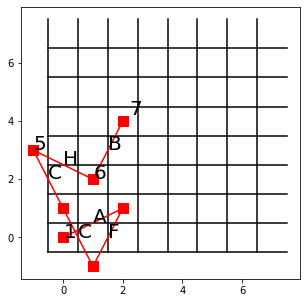

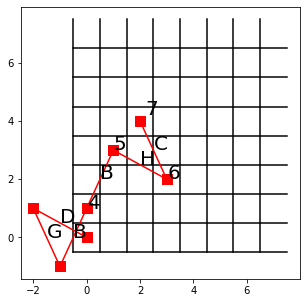

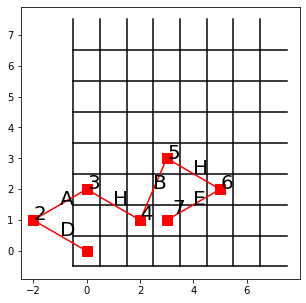

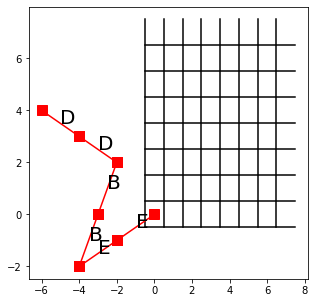

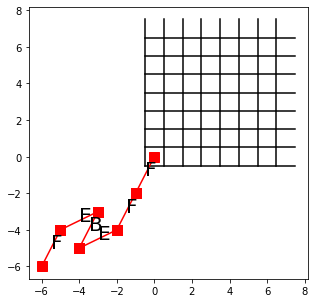

In [27]:
n_show = 10
for word in np.asarray(language)[np.random.permutation(len(language))[:n_show]]:
    plot_moves(word, center=True)

In [28]:
len(language)

126440

In [18]:
for word in get_paths(6)[10:20:2]:
    plot_moves(word)

ValueError: Parametter 'word_length' must be an even number

In [ ]:
for word in get_paths(4):
    plot_moves(word)

In [ ]:
for word in get_paths(2):
    plot_moves(word)

In [ ]:
def read_path_data(name,word_length=6):
        try:
            with open('./size_{}/{}/length_{}.txt'.format(BOARD_SIZE,name,word_length),'r') as language_file:
                return language_file.read().splitlines()
        except:
            try:
                os.mkdir('./size_{}'.format(BOARD_SIZE))
                os.mkdir('./size_{}/{}'.format(BOARD_SIZE,name))
            except:
                pass
            finally:
                return []

In [ ]:
# BIG TODO:
# Solucionar la simetría!
# Solucionar hacer el camino en sentido contrario too!
